In [65]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

df = pd.read_csv(r"C:\Users\alide\PycharmProjects\data-science-intro\data/column_2C_weka.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt numeric       310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


In [66]:
df.head(n = 5)
df['class'].unique()

array(['Abnormal', 'Normal'], dtype=object)

*Это медицинский набор данных: на основе него будем решать
задачу бинарной классификации пациентов, где пациент с признаком class = abnormal - имеет отклонения от нормы*

визуализируем данные на плоскости с помощью метода PCA

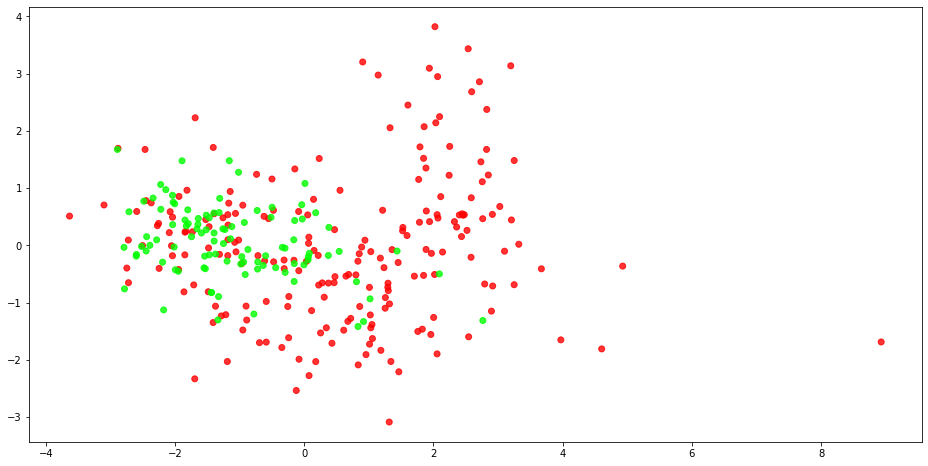

In [67]:
f0, axel0 = plt.subplots(1,1)
f0.set(figwidth = 16, figheight = 8)
def get_color1(i):
    Color = ["Lime", "Red"]
    return Color[i]

df["class"] = df["class"].apply(lambda x: 1 if x == "Abnormal" else 0)
a = df.iloc[:, :6].to_numpy()
scaler_a = StandardScaler()
a = scaler_a.fit_transform(a)
pca = PCA(n_components=2)
x_2d = pca.fit_transform(a)
axel0.scatter(x_2d[:, 0], x_2d[:, 1], color=[get_color1(i) for i in df["class"]], alpha=0.8)

видно что данные не являются линейно разделимыми, а напротив, перемешаны - значит здесь подойдет модель класификации KNN. Посмотрим есть ли выбросы в данных

<AxesSubplot:>

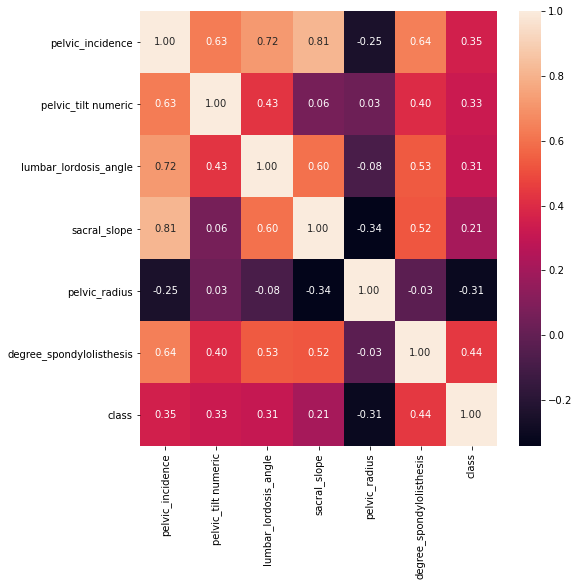

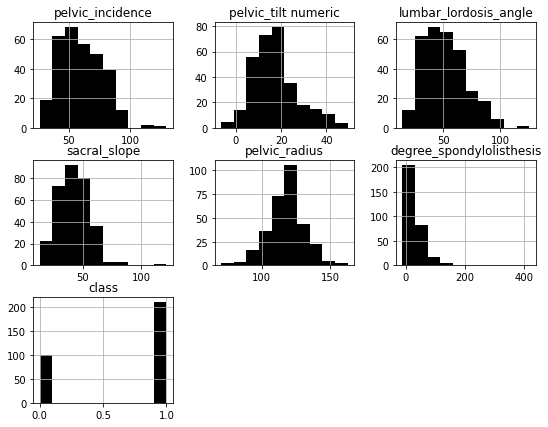

In [68]:
f1, axel1 = plt.subplots(1,1)
f1.set(figwidth = 8, figheight = 8)
df.hist(color="black", figsize = (9,7))
Corr = df.corr()
sns.heatmap(Corr, annot=True, fmt=".2f", ax = axel1)

из графиков видно что между некоторыми признаками есть высокая корреляция но т.к KNN это не линейная модель классификации, а метрическая, то признаки выбрасывать не будем. Заметили что в признаках есть выбросы, посмотрим на это подробнее

<AxesSubplot:>

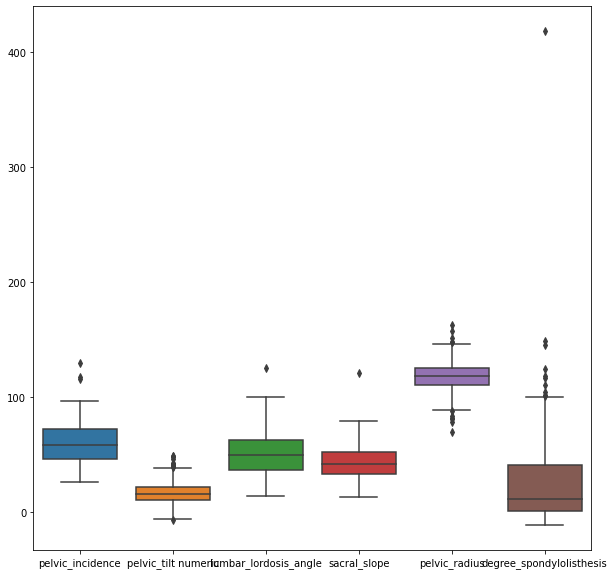

In [69]:
f2, axel2 = plt.subplots(1,1)
f2.set(figwidth = 10, figheight = 10)
sns.boxplot(data = df[['pelvic_incidence','pelvic_tilt numeric','lumbar_lordosis_angle','sacral_slope','pelvic_radius','degree_spondylolisthesis']], ax = axel2)

так как выбросы в данных есть, то придется данные почистить

In [70]:
def outlier_iqr(df, x, threshold):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    up_bound = q3 + threshold * iqr
    low_bound = q1 - threshold * iqr
    up = np.where(x < up_bound)
    low = np.where(x > low_bound)
    index = np.intersect1d(up,low)
    return df.iloc[index]

for i in range(df.columns.size-1):
    df = outlier_iqr(df,df[df.columns[i]],1.5)

<AxesSubplot:>

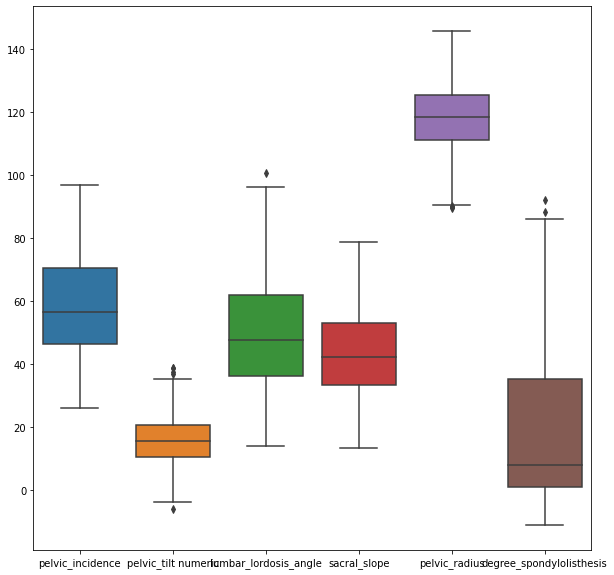

In [71]:
f3, axel3 = plt.subplots(1,1)
f3.set(figwidth = 10, figheight = 10)
sns.boxplot(data = df[['pelvic_incidence','pelvic_tilt numeric','lumbar_lordosis_angle','sacral_slope','pelvic_radius','degree_spondylolisthesis']], ax = axel3)

Теперь гораздо лучше. Посмотрим на  распределение классов

In [72]:
df["class"].value_counts(normalize=True)

1    0.641304
0    0.358696
Name: class, dtype: float64

Так выборка не сбалансированная, то при разбиении выборки на тренировочную и тестовую а также при кросс-валидации это будем учитывать. Данные готовы, теперь строим модель классификации KNN. 

In [73]:
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:, :6], df["class"], test_size=0.2, random_state=42, stratify=df["class"]
)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
#проверим баланс классов после разбивки
y_train.value_counts(normalize=True)

1    0.640909
0    0.359091
Name: class, dtype: float64

In [74]:
y_test.value_counts(normalize=True)

1    0.642857
0    0.357143
Name: class, dtype: float64

За базовый baseline прогноз возьмем метрику accuracy_baseline = 0.642857 - процент целевого класса class = 1 ('Abnormal')
так как в самом худшем случае алгоритм отнесет все объекты к классу 1, и получим как раз такую метрику, понятно что в лучшем случае accuracy должна быть выше.
Но кроссвалидировать будем по метрике которая обощает полноту и точность: F1 меру

In [75]:
param_grid = {"n_neighbors": np.arange(1, 51), "p": np.arange(1, 4), "weights": ["uniform", "distance"]}
knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits = 5,shuffle = True)
grid_search = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = param_grid, cv = cv, scoring = "f1")
Q = grid_search.fit(x_train_scaled, y_train)

лучшая метрика качества f1 на кроссвалидации

In [82]:
print('f1: {}'.format(Q.best_score_))

f1: 0.8672030614211618


лучшая метрика качества f1 на тестовой выборке

In [83]:
test_predictions = Q.best_estimator_.predict(x_test_scaled)
print('f1: {}'.format(f1_score(test_predictions, y_test)))

f1: 0.8767123287671232


лучшая метрика качеcтва accuracy на тестовой выборке

In [91]:
accuracy = accuracy_score(test_predictions, y_test)
print('accuracy: {}'.format(accuracy))

accuracy: 0.8392857142857143


сравним с baseline:

In [92]:
accuracy_baseline = 0.642857
print('лучше чем базовый прогноз на: {} %'.format(100*(accuracy - accuracy_baseline)/accuracy_baseline))

лучше чем базовый прогноз на: 30.55558456790768 %


### *Вывод: обученная модель  Knn на этих данных адекватно предсказывает целевой класс*